# Transfer Learning with Resnet50 for Nexperia Image Classification II 

Author: WONG Wing Kin

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import cv2

import os
import tensorflow
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense , Flatten , BatchNormalization , Dropout



### Let's set some parameter

In [2]:
# Fixed for our Cats & Dogs classes
NUM_CLASSES = 1

# Fixed for Cats & Dogs color images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'sigmoid'
OBJECTIVE_FUNCTION = 'binary_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = [
      tensorflow.keras.metrics.TruePositives(name='tp'),
      tensorflow.keras.metrics.FalsePositives(name='fp'),
      tensorflow.keras.metrics.TrueNegatives(name='tn'),
      tensorflow.keras.metrics.FalseNegatives(name='fn'), 
      tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
      tensorflow.keras.metrics.Precision(name='precision'),
      tensorflow.keras.metrics.Recall(name='recall'),
      tensorflow.keras.metrics.AUC(name='auc'),
]

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 50
EARLY_STOP_PATIENCE = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

## Model

We removed the top layer in the pre-trained model, and add the new Dense layer.

In [5]:
resnet50_imagenet_model = ResNet50(include_top=False , pooling = RESNET50_POOLING_AVERAGE, weights='imagenet', input_shape=(224, 224, 3))

#Flatten output layer of Resnet
flattened = tf.keras.layers.Flatten()(resnet50_imagenet_model.output)

#Fully connected layer 1
fc1 = tf.keras.layers.Dense(128, activation='relu', name="AddedDense1")(flattened)

#Fully connected layer, output layer
fc2 = tf.keras.layers.Dense(1, activation='sigmoid', name="AddedDense2")(fc1)

model = tf.keras.models.Model(inputs=resnet50_imagenet_model.input, outputs=fc2)

model.summary()

94773248/94765736 [==============================] - 4s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________

## Data Loader

Let's prepare the image for training. Here, we will crop the 20 pixels near the boundary.

In [6]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from scipy import ndimage
import pathlib
image_size = IMAGE_RESIZE

def filter(img):
    img = ndimage.uniform_filter(img, 5)
    img[:20,:,0] = 0
    img[247:,:,0] = 0
    img[:,:20,0] = 0
    img[:,255:,0] = 0
    return preprocess_input(img)

data_dir = pathlib.Path("/kaggle/input/semi-conductor-image-classification-second-stage/train/train_contest") 
test_dir = pathlib.Path("/kaggle/input/semi-conductor-image-classification-second-stage/test/test_contest")

data_generator = ImageDataGenerator(validation_split=0.2,preprocessing_function=filter)
test_data_generator = ImageDataGenerator(preprocessing_function=filter)


train_generator = data_generator.flow_from_directory(
        data_dir,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING, classes=["good_all", "defect"],
        class_mode='binary' , subset='training')

validation_generator = data_generator.flow_from_directory(
        data_dir,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION, classes=["good_all", "defect"],
        class_mode='binary' , subset='validation') 

test_generator = test_data_generator.flow_from_directory(
        test_dir,
        shuffle=False,
        target_size=(image_size, image_size),
        batch_size = 1) 


total_train = len(train_generator.labels)
total_val = len(validation_generator.labels)


Found 27568 images belonging to 2 classes.
Found 6891 images belonging to 2 classes.
Found 3830 images belonging to 1 classes.


Let's preview the value in the variable

In [7]:

(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(100, 276, 100, 69)

Do Early Stopping and Save the best model during training.

p.s. I have disabled early stopping here.

In [8]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_auc', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5',verbose=1, monitor = 'val_auc', save_best_only = True, mode = 'max')

## Training

In [9]:
from tensorflow.python.keras import optimizers

sgd = tensorflow.keras.optimizers.Adam()
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

history = model.fit(
    train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer]
)




Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 0.5039 - tp: 64.0000 - fp: 63.0000 - tn: 742.0000 - fn: 131.0000 - accuracy: 0.8060 - precision: 0.5039 - recall: 0.3282 - auc: 0.7612
Epoch 00001: val_auc improved from -inf to 0.54864, saving model to ../working/best.hdf5
10/10 [==============================] - 18s 2s/step - loss: 0.5039 - tp: 64.0000 - fp: 63.0000 - tn: 742.0000 - fn: 131.0000 - accuracy: 0.8060 - precision: 0.5039 - recall: 0.3282 - auc: 0.7612 - val_loss: 4.0319 - val_tp: 200.0000 - val_fp: 799.0000 - val_tn: 0.0000e+00 - val_fn: 1.0000 - val_accuracy: 0.2000 - val_precision: 0.2002 - val_recall: 0.9950 - val_auc: 0.5486
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 0.2414 - tp: 120.0000 - fp: 21.0000 - tn: 788.0000 - fn: 71.0000 - accuracy: 0.9080 - precision: 0.8511 - recall: 0.6283 - auc: 0.9242
Epoch 00002: val_auc did not improve from 0.54864
10/10 [==============================] - 16s 2s/step - loss: 0.2414 - tp: 120.

Epoch 14/50
10/10 [==============================] - ETA: 0s - loss: 0.0664 - tp: 179.0000 - fp: 7.0000 - tn: 799.0000 - fn: 15.0000 - accuracy: 0.9780 - precision: 0.9624 - recall: 0.9227 - auc: 0.9900
Epoch 00014: val_auc did not improve from 0.88076
10/10 [==============================] - 14s 1s/step - loss: 0.0664 - tp: 179.0000 - fp: 7.0000 - tn: 799.0000 - fn: 15.0000 - accuracy: 0.9780 - precision: 0.9624 - recall: 0.9227 - auc: 0.9900 - val_loss: 1.2756 - val_tp: 47.0000 - val_fp: 2.0000 - val_tn: 806.0000 - val_fn: 145.0000 - val_accuracy: 0.8530 - val_precision: 0.9592 - val_recall: 0.2448 - val_auc: 0.7039
Epoch 15/50
10/10 [==============================] - ETA: 0s - loss: 0.1060 - tp: 185.0000 - fp: 18.0000 - tn: 776.0000 - fn: 21.0000 - accuracy: 0.9610 - precision: 0.9113 - recall: 0.8981 - auc: 0.9866
Epoch 00015: val_auc improved from 0.88076 to 0.89624, saving model to ../working/best.hdf5
10/10 [==============================] - 15s 1s/step - loss: 0.1060 - tp: 185.

Epoch 27/50
10/10 [==============================] - ETA: 0s - loss: 0.0783 - tp: 219.0000 - fp: 21.0000 - tn: 753.0000 - fn: 7.0000 - accuracy: 0.9720 - precision: 0.9125 - recall: 0.9690 - auc: 0.9946
Epoch 00027: val_auc did not improve from 0.89624
10/10 [==============================] - 14s 1s/step - loss: 0.0783 - tp: 219.0000 - fp: 21.0000 - tn: 753.0000 - fn: 7.0000 - accuracy: 0.9720 - precision: 0.9125 - recall: 0.9690 - auc: 0.9946 - val_loss: 0.5203 - val_tp: 161.0000 - val_fp: 149.0000 - val_tn: 649.0000 - val_fn: 41.0000 - val_accuracy: 0.8100 - val_precision: 0.5194 - val_recall: 0.7970 - val_auc: 0.8898
Epoch 28/50
10/10 [==============================] - ETA: 0s - loss: 0.0831 - tp: 178.0000 - fp: 15.0000 - tn: 789.0000 - fn: 18.0000 - accuracy: 0.9670 - precision: 0.9223 - recall: 0.9082 - auc: 0.9873
Epoch 00028: val_auc improved from 0.89624 to 0.89959, saving model to ../working/best.hdf5
10/10 [==============================] - 14s 1s/step - loss: 0.0831 - tp: 17

Epoch 40/50
10/10 [==============================] - ETA: 0s - loss: 0.0635 - tp: 184.0000 - fp: 4.0000 - tn: 797.0000 - fn: 15.0000 - accuracy: 0.9810 - precision: 0.9787 - recall: 0.9246 - auc: 0.9949
Epoch 00040: val_auc did not improve from 0.94898
10/10 [==============================] - 12s 1s/step - loss: 0.0635 - tp: 184.0000 - fp: 4.0000 - tn: 797.0000 - fn: 15.0000 - accuracy: 0.9810 - precision: 0.9787 - recall: 0.9246 - auc: 0.9949 - val_loss: 0.3975 - val_tp: 141.0000 - val_fp: 50.0000 - val_tn: 750.0000 - val_fn: 59.0000 - val_accuracy: 0.8910 - val_precision: 0.7382 - val_recall: 0.7050 - val_auc: 0.8704
Epoch 41/50
10/10 [==============================] - ETA: 0s - loss: 0.0770 - tp: 183.0000 - fp: 15.0000 - tn: 788.0000 - fn: 14.0000 - accuracy: 0.9710 - precision: 0.9242 - recall: 0.9289 - auc: 0.9891
Epoch 00041: val_auc did not improve from 0.94898
10/10 [==============================] - 13s 1s/step - loss: 0.0770 - tp: 183.0000 - fp: 15.0000 - tn: 788.0000 - fn: 1

In [10]:
def plot_metrics(history):
  plt.figure(figsize=(10,10))
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

Let's see the training graph below:

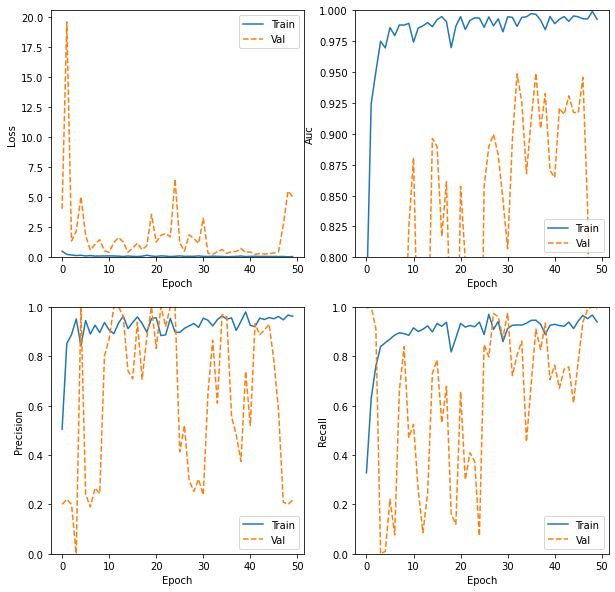

In [11]:
plot_metrics(history)

Generate Output for testing

In [12]:
result = model.predict(test_generator, verbose=1).flatten()
output = pd.DataFrame(columns=['id', 'defect_score'])
index = 0
for child in test_dir.glob('test/*'):
    output = output.append({'id': test_generator.filepaths[index].split("/")[-1].split(".")[0] , 'defect_score' : result[index] }, ignore_index=True)
    index = index + 1


output.to_csv('/kaggle/working/submission.csv', index=False)
output


3830/3830 [==============================] - 39s 10ms/step


,id,defect_score
0,WEA93800193A_31-5CW-ITISA49-2_337_3,1.000000
1,WEA93800193A_46-5CW-ITISA49-2_227_3,0.996911
2,WEA93800193A_51-5CW-ITISA49-1_47_3,0.994593
3,WEA93800194A_11-5CW-ITISA49-1_194_1,0.983753
4,WEA93800194A_25-5CW-ITISA49-1_24_3,0.946599
...,...,...
3825,WEP93950811A_42-APG_ITIS_H47_2_362_2,1.000000
3826,WEP939522H1A_11-APG_ITIS_H09_2_59_4,0.999911
3827,WEP939522H1A_37-APG_ITIS_H166_2_355_2,1.000000
3828,WEP939559B2A_24-APG_ITIS_H56_1_85_4,0.999722


In [13]:
model.load_weights("../working/best.hdf5")
result = model.predict(test_generator, verbose=1).flatten()
output = pd.DataFrame(columns=['id', 'defect_score'])
index = 0
for child in test_dir.glob('test/*'):
    output = output.append({'id': test_generator.filepaths[index].split("/")[-1].split(".")[0] , 'defect_score' : result[index] }, ignore_index=True)
    index = index + 1


output.to_csv('/kaggle/working/submission_best.csv', index=False)
output


3830/3830 [==============================] - 38s 10ms/step


,id,defect_score
0,WEA93800193A_31-5CW-ITISA49-2_337_3,0.978311
1,WEA93800193A_46-5CW-ITISA49-2_227_3,0.547320
2,WEA93800193A_51-5CW-ITISA49-1_47_3,0.654393
3,WEA93800194A_11-5CW-ITISA49-1_194_1,0.000286
4,WEA93800194A_25-5CW-ITISA49-1_24_3,0.004066
...,...,...
3825,WEP93950811A_42-APG_ITIS_H47_2_362_2,0.991562
3826,WEP939522H1A_11-APG_ITIS_H09_2_59_4,0.675723
3827,WEP939522H1A_37-APG_ITIS_H166_2_355_2,1.000000
3828,WEP939559B2A_24-APG_ITIS_H56_1_85_4,0.932922


In [14]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

decode_predictions = keras.applications.resnet50.decode_predictions



In [19]:
for layer in model.layers:
    print(layer.name)
    
last_conv_layer_name = "conv5_block3_out"
classifier_layer_names = "conv5_block3_out"
classifier_layer_names = [
    "avg_pool",
    "flatten",
    "AddedDense1",
    "AddedDense2",
]


input_1
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

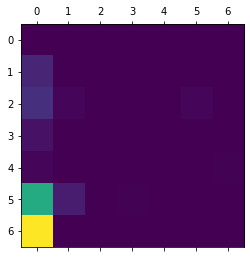

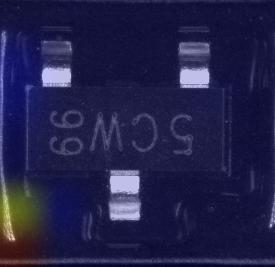

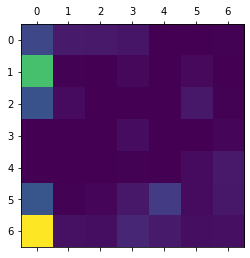

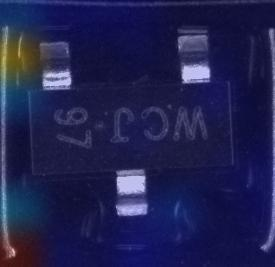

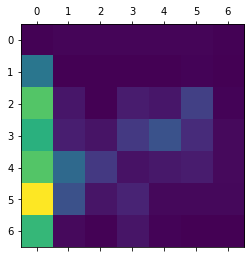

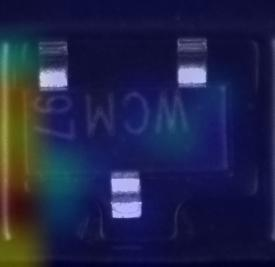

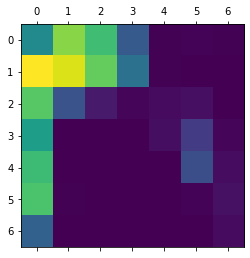

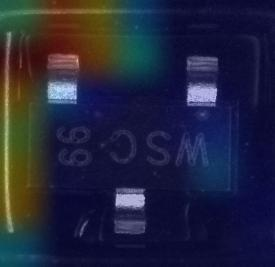

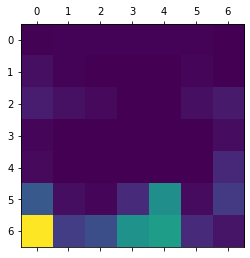

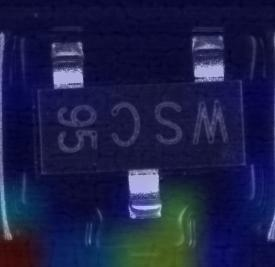

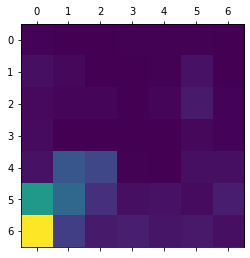

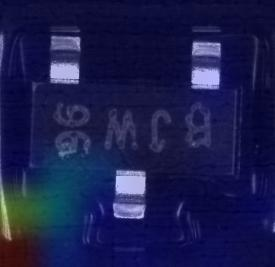

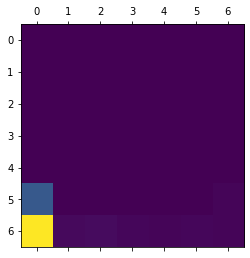

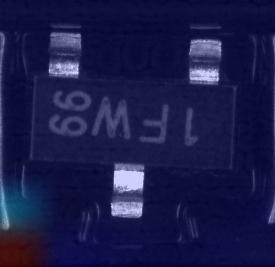

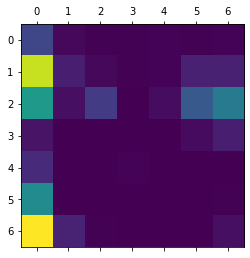

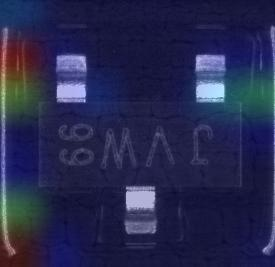

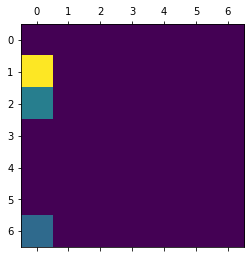

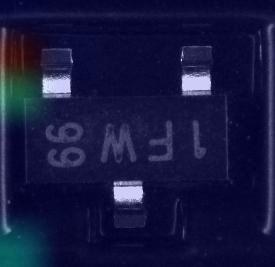

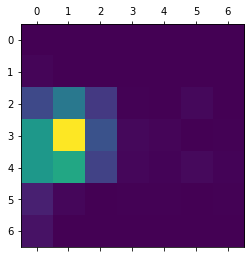

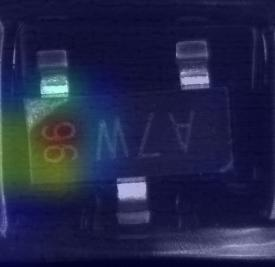

In [20]:
import random

for img_path in  random.choices(validation_generator.filepaths, k=10):
    img_array = filter(get_img_array(img_path, size=(224,224,3)))

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(
        img_array, model, last_conv_layer_name, classifier_layer_names
    )

    # Display heatmap
    plt.matshow(heatmap)
    plt.show()

    # We load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    save_path = "elephant_cam.jpg"
    superimposed_img.save(save_path)

    # Display Grad CAM
    display(Image(save_path))

Let's preview the defect area data.

In [21]:
defect_area = pd.read_csv("/kaggle/input/semi-conductor-image-classification-second-stage/defect_area.csv")


defect_area['width'] = defect_area['x_2'] - defect_area['x_1']
defect_area['height'] = defect_area['y_2'] - defect_area['y_1']

defect_area

,id,x_1,y_1,x_2,y_2,width,height
0,SOT23DUMMY01_04-APG_ITIS_H52_1_111_4,40,100,99,198,59,98
1,SOT23DUMMY01_09-APG_ITIS_H52_1_12_3,28,90,242,204,214,114
2,WEA938001D1A_17-APG_ITIS_H49_1_40_2,10,131,52,179,42,48
3,WEA938001D1A_48-APG_ITIS_H51_2_203_1,25,86,229,175,204,89
4,WEE939001B0A_14-APG_ITIS_H20_1_374_4,106,90,242,134,136,44
...,...,...,...,...,...,...,...
6691,WEP93953252A_02-APG_ITIS_H53_2_340_4,39,166,191,197,152,31
6692,WEP93955394A_44-APG_ITIS_H52_2_360_1,25,107,241,195,216,88
6693,WEP93955452A_06-APG_ITIS_H51_1_230_4,151,87,226,117,75,30
6694,WEP93955514A_57-APG_ITIS_H54_2_138_2,172,147,227,171,55,24


Let's see the activation heatmap. The red rectangle are the defect area given in the dataset.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


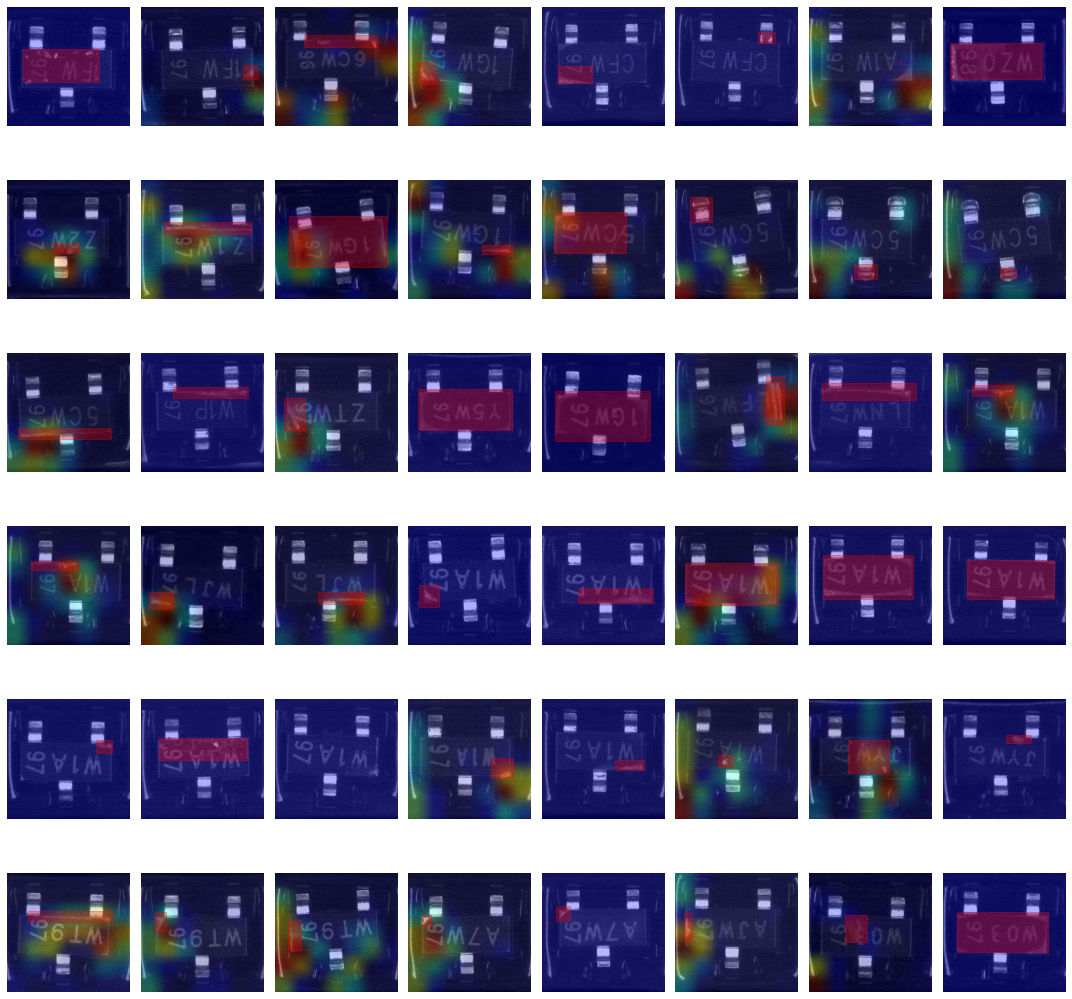

In [24]:
fig, axes = plt.subplots(6,8, figsize=(15,15))
axes = axes.flatten()
index = 50
for ax in axes:
        img_path = '../input/semi-conductor-image-classification-second-stage/train/train_contest/defect/'+defect_area.loc[index]['id']+'.bmp'
        img_array = filter(get_img_array(img_path, size=(224,224,3)))

        # Generate class activation heatmap
        heatmap = make_gradcam_heatmap(
            img_array, model, last_conv_layer_name, classifier_layer_names
        )       

        # We load the original image
        img = keras.preprocessing.image.load_img(img_path)
        img = keras.preprocessing.image.img_to_array(img)

        # We rescale heatmap to a range 0-255
        heatmap = np.uint8(255 * heatmap)

        # We use jet colormap to colorize heatmap
        jet = cm.get_cmap("jet")

        # We use RGB values of the colormap
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        # We create an image with RGB colorized heatmap
        jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

        # Superimpose the heatmap on original image
        superimposed_img = jet_heatmap * 0.4 + img
        superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

        # Save the superimposed image
        save_path = "elephant_cam.jpg"
        superimposed_img.save(save_path)
        img = plt.imread(save_path)
        
        ax.axvspan(defect_area.loc[index]['x_1'], defect_area.loc[index]['x_2'], 
                   (275-defect_area.loc[index]['y_1'])/275 , (275-defect_area.loc[index]['y_2'])/275 , color='red', alpha=0.3)
        #print(img.shape)
        ax.imshow(img)
        ax.axis('off')
        index = index + 1

plt.tight_layout()
plt.show()

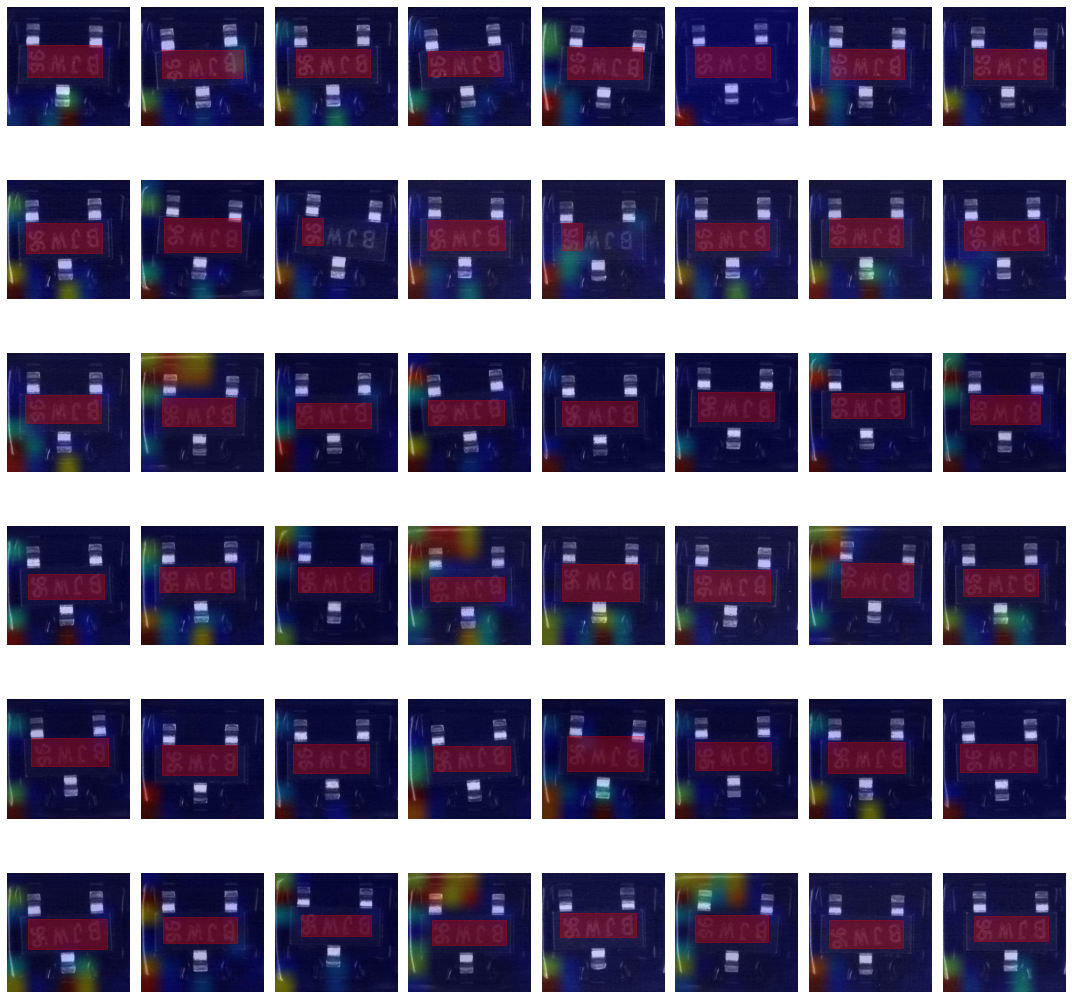

In [22]:
fig, axes = plt.subplots(6,8, figsize=(15,15))
axes = axes.flatten()
index = 350
for ax in axes:
        img_path = '../input/semi-conductor-image-classification-second-stage/train/train_contest/defect/'+defect_area.loc[index]['id']+'.bmp'
        img_array = filter(get_img_array(img_path, size=(224,224,3)))

        # Generate class activation heatmap
        heatmap = make_gradcam_heatmap(
            img_array, model, last_conv_layer_name, classifier_layer_names
        )       

        # We load the original image
        img = keras.preprocessing.image.load_img(img_path)
        img = keras.preprocessing.image.img_to_array(img)

        # We rescale heatmap to a range 0-255
        heatmap = np.uint8(255 * heatmap)

        # We use jet colormap to colorize heatmap
        jet = cm.get_cmap("jet")

        # We use RGB values of the colormap
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        # We create an image with RGB colorized heatmap
        jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

        # Superimpose the heatmap on original image
        superimposed_img = jet_heatmap * 0.4 + img
        superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

        # Save the superimposed image
        save_path = "elephant_cam.jpg"
        superimposed_img.save(save_path)
        img = plt.imread(save_path)
        
        ax.axvspan(defect_area.loc[index]['x_1'], defect_area.loc[index]['x_2'], 
                   (275-defect_area.loc[index]['y_1'])/275 , (275-defect_area.loc[index]['y_2'])/275 , color='red', alpha=0.3)
        #print(img.shape)
        ax.imshow(img)
        ax.axis('off')
        index = index + 1

plt.tight_layout()
plt.show()

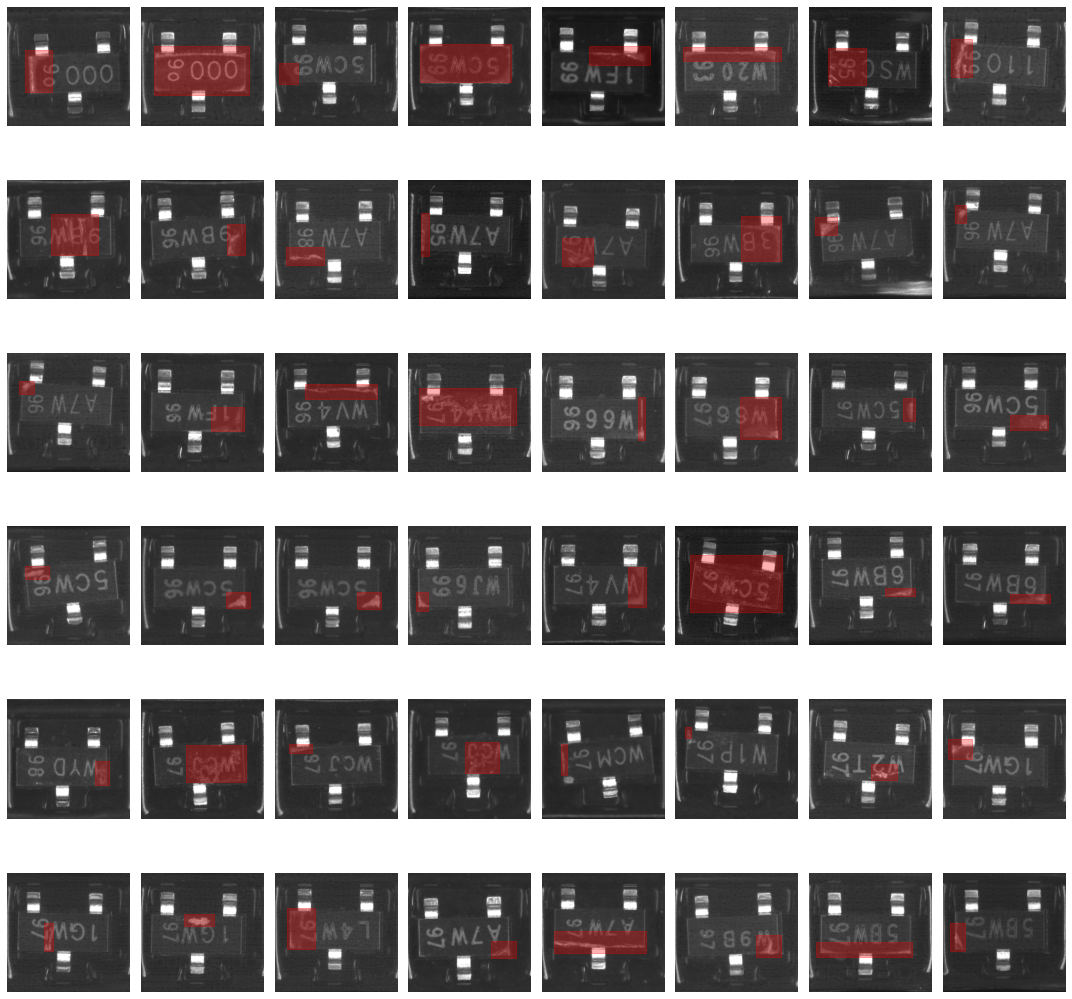

In [23]:
fig, axes = plt.subplots(6,8, figsize=(15,15))
axes = axes.flatten()
index = 0
for ax in axes:
        img = plt.imread('../input/semi-conductor-image-classification-second-stage/train/train_contest/defect/'+defect_area.loc[index]['id']+'.bmp')
        img = img.reshape(267,275,1)
        #print(type(img))
        
        img = np.concatenate((img, img,img), axis=2)
        #print(defect_area.loc[index]['x_2'])
        ax.axvspan(defect_area.loc[index]['x_1'], defect_area.loc[index]['x_2'], 
                   (275-defect_area.loc[index]['y_1'])/275 , (275-defect_area.loc[index]['y_2'])/275 , color='red', alpha=0.3)
        #print(img.shape)
        ax.imshow(img)
        
        ax.axis('off')
        index = index + 1

plt.tight_layout()
plt.show()